In [57]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re, string, unicodedata
from string import punctuation
from termcolor import colored
from collections import Counter


from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer

import nltk
from nltk.corpus import stopwords
from textblob import Word
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet


from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

[nltk_data] Downloading package stopwords to /Users/zap/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/zap/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/zap/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [58]:
true_news = pd.read_csv("../../Dataset/Fake and Real News Dataset/True.csv") 
# this folder structure works on both kaggle and local machine

fake_news = pd.read_csv("../../Dataset/Fake and Real News Dataset/Fake.csv") 

In [59]:
true_news.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [60]:
fake_news.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [61]:
true_news['new_class'], fake_news['new_class'] = 1, 0

news = pd.concat([true_news, fake_news])

In [62]:
news.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  new_class  
0  December 31, 2017           1  
1  December 29, 2017           1  
2  December 31, 2017           1  
3  December 30, 2017           1  
4  December 29, 2017           1

In [63]:
news.info(memory_usage=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      44898 non-null  object
 1   text       44898 non-null  object
 2   subject    44898 non-null  object
 3   date       44898 non-null  object
 4   new_class  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [64]:
news.duplicated().sum()

209

In [65]:
#drop duplicates
news.drop_duplicates(inplace= True)

In [66]:
grouped_by_class = news.groupby('new_class').count()
grouped_by_class

title   text  subject   date
new_class                              
0          23478  23478    23478  23478
1          21211  21211    21211  21211

In [67]:
news.isnull().sum()

title        0
text         0
subject      0
date         0
new_class    0
dtype: int64

In [68]:
news['subject'].value_counts()

subject
politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64

In [69]:
news['title'].count()

44689

## EDA

In [70]:
x = news['new_class'].value_counts()
x

new_class
0    23478
1    21211
Name: count, dtype: int64

[Text(0.5, 1.0, 'Class Freq')]

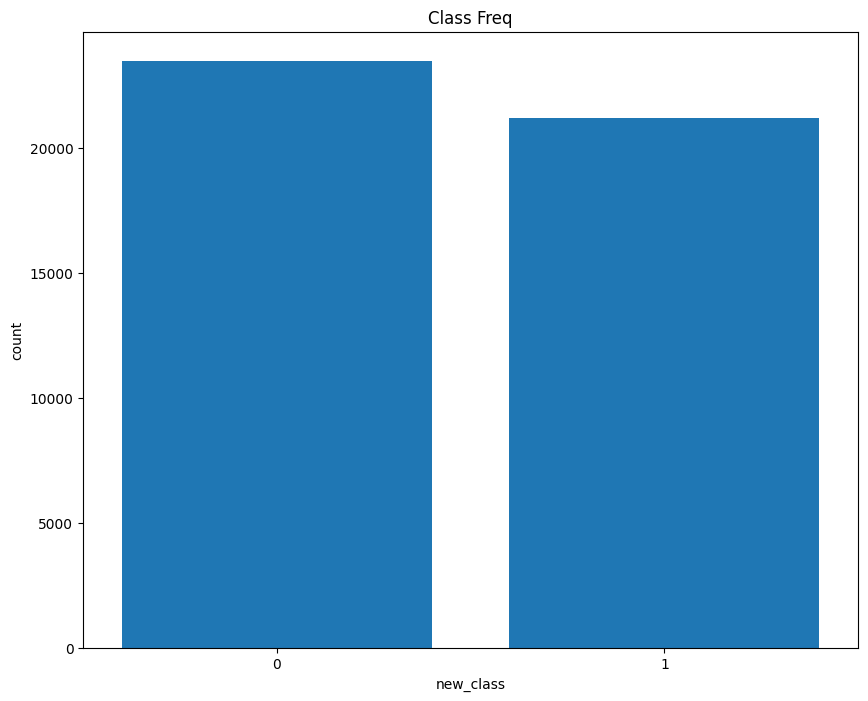

In [71]:
plt.figure(figsize= [ 10, 8] , clear = True, facecolor = 'white' )

sns.barplot(x = news['new_class'].value_counts().index,
            y = news['new_class'].value_counts(),
            saturation = 1).set(title  = 'Class Freq')

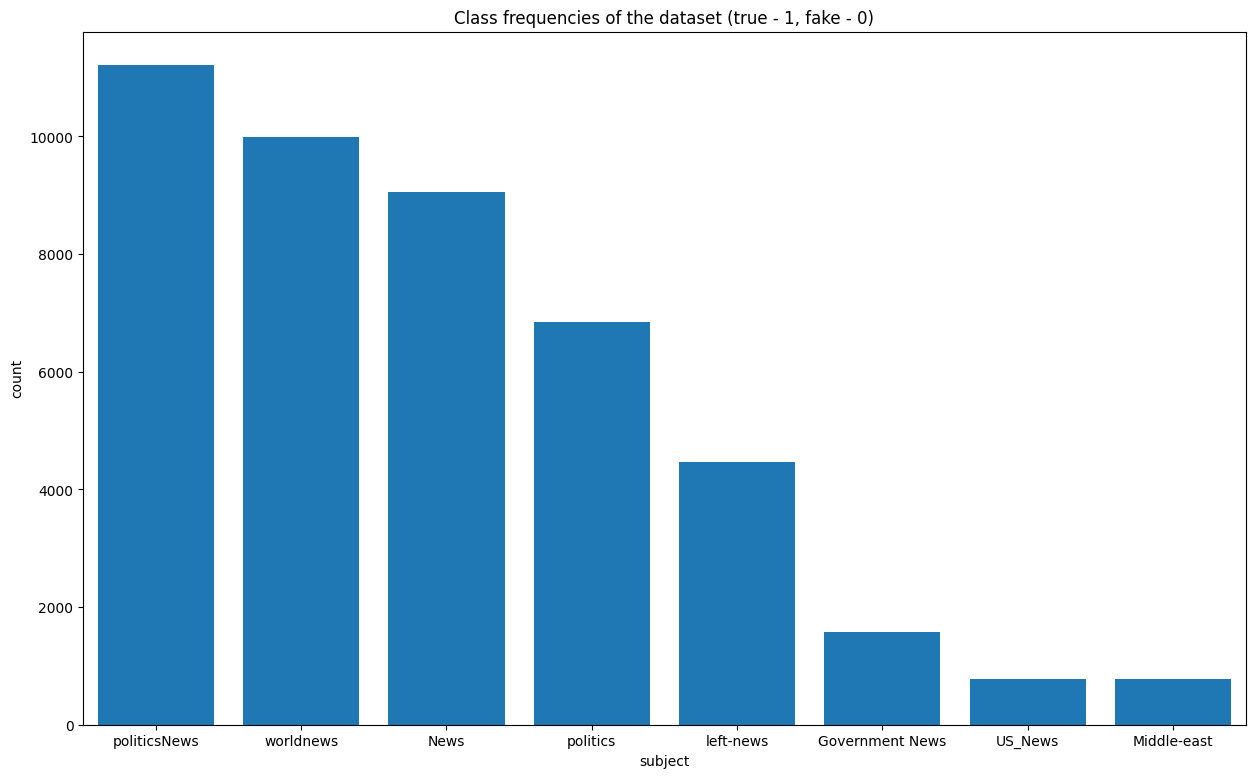

In [72]:
plt.figure(figsize = [15, 9], clear = True, facecolor = 'white')

sns.barplot(x = news["subject"].value_counts().index,
            y = news["subject"].value_counts(),
            saturation = 1).set(title = "Class frequencies of the dataset (true - 1, fake - 0)");

## Data Processing before LSTM

In [73]:
news['text'] = news['text'] + " " + news['title']

news.drop(['title', 'date', 'subject' ], axis =1, inplace=True )

In [74]:
news.head()

text  new_class
0  WASHINGTON (Reuters) - The head of a conservat...          1
1  WASHINGTON (Reuters) - Transgender people will...          1
2  WASHINGTON (Reuters) - The special counsel inv...          1
3  WASHINGTON (Reuters) - Trump campaign adviser ...          1
4  SEATTLE/WASHINGTON (Reuters) - President Donal...          1

In [75]:
news['text'] = news['text'].apply(lambda x : " ".join(x.lower() for x in x.split() ) )

In [76]:
news.head()

text  new_class
0  washington (reuters) - the head of a conservat...          1
1  washington (reuters) - transgender people will...          1
2  washington (reuters) - the special counsel inv...          1
3  washington (reuters) - trump campaign adviser ...          1
4  seattle/washington (reuters) - president donal...          1

In [77]:
# Replace punctuation with space
news['text'] = news['text'].str.replace('[^\w\s]','')

In [78]:
# Replace number with space
news['text'] = news['text'].str.replace('\d', '' )

In [79]:
# Remove Stop words
stop_words = set(stopwords.words('english'))
punctuation = list(string.punctuation)

stop_words.update(punctuation)

news['text'] = news['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words ) )

news.head()

text  new_class
0  washington (reuters) head conservative republi...          1
1  washington (reuters) transgender people allowe...          1
2  washington (reuters) special counsel investiga...          1
3  washington (reuters) trump campaign adviser ge...          1
4  seattle/washington (reuters) president donald ...          1

In [80]:
# lematize words
news['text'] = news['text'].apply(lambda x : " ".join([Word(word).lemmatize() for word in x.split()]) )

In [81]:
news['text'] = news['text'].apply(lambda x : " ".join(re.sub(r'http\S+', '', x ) for x in x.split() ) )

In [82]:
news.head(n = 15).style.background_gradient(cmap = 'summer')

Text(0.5, 1.0, 'Distribution of Text length for True News')

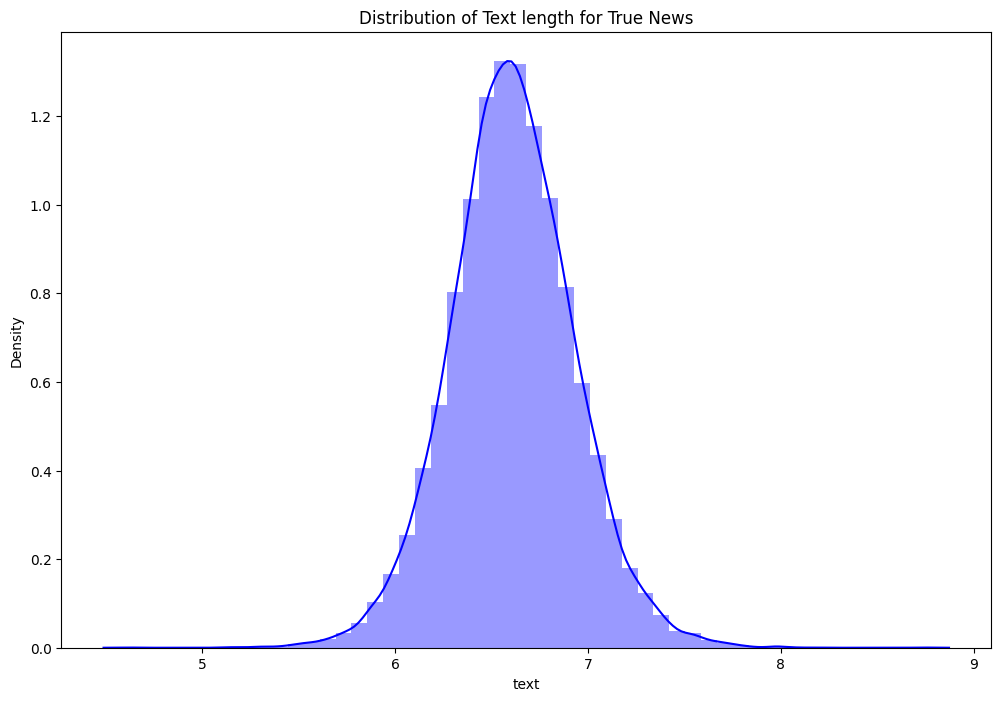

In [83]:
fix, ax = plt.subplots(figsize = (12, 8))

text_words = news[news['new_class'] == 1 ]['text'].str.split().apply(lambda x : [len(i) for i in x])

sns.distplot(text_words.map(lambda x : np.mean(x)), color = 'blue', ax = ax ).set_title('Distribution of Text length for True News')

Text(0.5, 1.0, 'Distribution of Text length for Fake News')

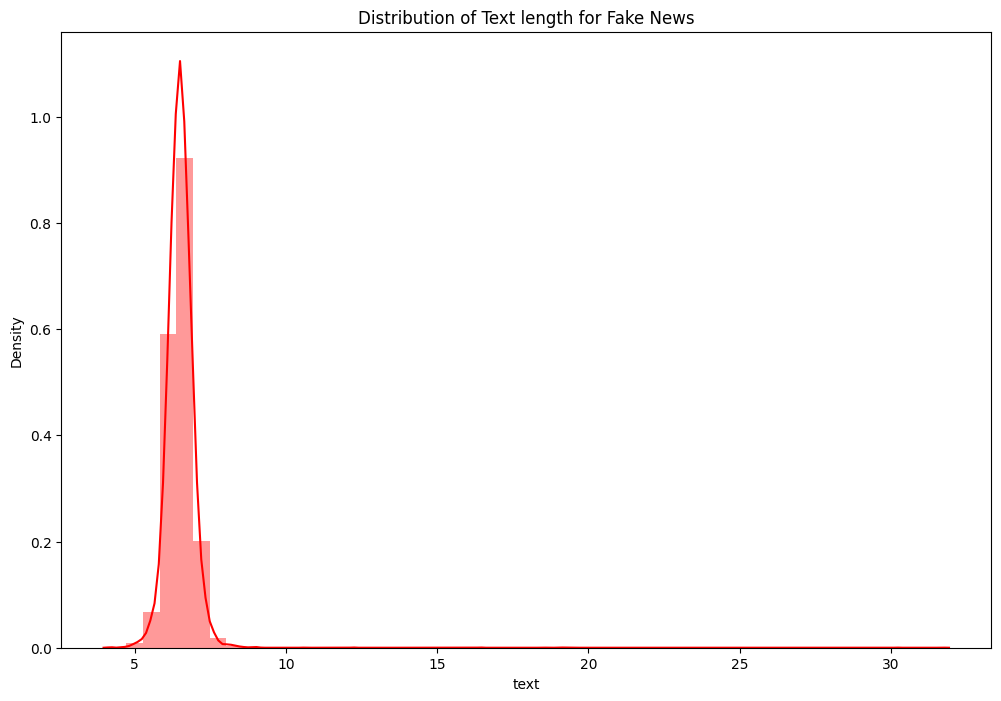

In [84]:
fix, ax = plt.subplots(figsize = (12, 8))

text_words = news[news['new_class'] == 0 ]['text'].str.split().apply(lambda x : [len(i) for i in x])

sns.distplot(text_words.map(lambda x : np.mean(x)), color = 'red', ax = ax ).set_title('Distribution of Text length for Fake News')

## Data Preparation for LSTM

In [85]:
x = news['text']

y = news['new_class']

train_x, test_x, train_y, test_y = train_test_split(x,y, test_size = 0.25, shuffle = True, random_state=11)

In [86]:
print(train_x.shape, test_x.shape)

(33516,) (11173,)


In [87]:
tokenizer = Tokenizer(num_words=10000)

'''Build a vocabulary of words
Calculate word frequencies
Create a word-to-index mapping (dictionary)'''

tokenizer.fit_on_texts(train_x)

# word index dictionary
# feed textual darta -> convert to number

'''The texts_to_sequences() function converts each text into a sequence of integers, where each integer represents a word from the vocabulary'''
tokenized_train = tokenizer.texts_to_sequences(train_x)
tokenized_test = tokenizer.texts_to_sequences(test_x)


In [88]:
#vector representation of global texts to vectorize our corpus
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype = "float32")

glove_twitter = "../..//Dataset/Glove Twitter Archive/glove.twitter.27B.100d.txt"
embeddings_index = dict(get_coefs(*g.rstrip().rsplit(" ")) for g in open(glove_twitter))
'''Opens the GloVe file
For each line g in the file:
Removes trailing whitespace with rstrip()
Splits the line by spaces using rsplit(" ")
The first element is the word, and the rest are the vector components
Passes these as arguments to get_coefs() using the * operator to unpack
Creates a dictionary where:
Keys are words (strings)
Values are their corresponding 100-dimensional embedding vectors (NumPy arrays)
'''
# rstrip -> remove whitespace
# dict form of vector value
# get embedding index from global vector

'''GloVe (Global Vectors for Word Representation) is a technique used to create vector representations of words, commonly known as word embeddings.'''
# => global context, semantic representation, facilating NLP tasks
embeddings_index

{'<user>': array([ 0.63006  ,  0.65177  ,  0.25545  ,  0.018593 ,  0.043094 ,
         0.047194 ,  0.23218  ,  0.11613  ,  0.17371  ,  0.40487  ,
         0.022524 , -0.076731 , -2.2911   ,  0.094127 ,  0.43293  ,
         0.041801 ,  0.063175 , -0.64486  , -0.43657  ,  0.024114 ,
        -0.082989 ,  0.21686  , -0.13462  , -0.22336  ,  0.39436  ,
        -2.1724   , -0.39544  ,  0.16536  ,  0.39438  , -0.35182  ,
        -0.14996  ,  0.10502  , -0.45937  ,  0.27729  ,  0.8924   ,
        -0.042313 , -0.009345 ,  0.55017  ,  0.095521 ,  0.070504 ,
        -1.1781   ,  0.013723 ,  0.17742  ,  0.74142  ,  0.17716  ,
         0.038468 , -0.31684  ,  0.08941  ,  0.20557  , -0.34328  ,
        -0.64303  , -0.878    , -0.16293  , -0.055925 ,  0.33898  ,
         0.60664  , -0.2774   ,  0.33626  ,  0.21603  , -0.11051  ,
         0.0058673, -0.64757  , -0.068222 , -0.77414  ,  0.13911  ,
        -0.15851  , -0.61885  , -0.10192  , -0.47     ,  0.19787  ,
         0.42175  , -0.18458  ,  0.080

In [89]:
#Prepare weihts and embedding matrix before feeding into LSTM model
# pretrained word embedding in a keras model
# every keras layer have attribute weights implemented -> cannot find weights in keras layer

In [90]:
embedding = np.stack(embeddings_index.values())

embedding_mean, embedding_std = embedding.mean(), embedding.std()

embedding_size = embedding.shape[1]

word_index = tokenizer.word_index

nb_word = min(10000, len(word_index))

# print(embedding_mean, embedding_std, embedding_size)
print(nb_word)

10000


In [91]:
tokenizer.word_index.items()

dict_items([('trump', 1), ('said', 2), ('u', 3), ('president', 4), ('s', 5), ('would', 6), ('state', 7), ('people', 8), ('”', 9), ('republican', 10), ('one', 11), ('year', 12), ('new', 13), ('also', 14), ('house', 15), ('clinton', 16), ('government', 17), ('reuters', 18), ('donald', 19), ('obama', 20), ('say', 21), ('time', 22), ('white', 23), ('election', 24), ('american', 25), ('could', 26), ('like', 27), ('united', 28), ('told', 29), ('country', 30), ('right', 31), ('campaign', 32), ('party', 33), ('two', 34), ('news', 35), ('last', 36), ('official', 37), ('first', 38), ('the', 39), ('video', 40), ('washington', 41), ('law', 42), ('hillary', 43), ('make', 44), ('former', 45), ('group', 46), ('even', 47), ('get', 48), ('day', 49), ('security', 50), ('many', 51), ('vote', 52), ('it', 53), ('court', 54), ('may', 55), ('national', 56), ('police', 57), ('want', 58), ('week', 59), ('political', 60), ('made', 61), ('bill', 62), ('million', 63), ('back', 64), ('since', 65), ('leader', 66), 

In [92]:
# calculate embedding matrix from normal distribution of embedidng.mean and embedidng.std
embedding_matrix = np.random.normal(embedding_mean, embedding_std, (nb_word, embedding_size))

for word, i in word_index.items():
    if i >= 10000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector



In [99]:
# Reduce learning rate when a metric has stopped improving 
lr_reduce = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 2, factor = 0.5, min_lr = 0.00001 )


In [103]:
model = Sequential()

model.add(Embedding(10000, output_dim=100, weights = [embedding_matrix], input_length=300, trainable = False ))

model.add(LSTM(units = 128, return_sequences=True, recurrent_dropout=0.3, dropout = 0.3))

model.add(LSTM(units = 64, recurrent_dropout = 0.15,
               dropout = 0.15))

model.add(Dense(units = 32, activation= 'relu' ))

model.add(Dense(1, activation = 'sigmoid' ))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics=['accuracy'] )

In [95]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [108]:
# Import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Pad sequences to ensure uniform length
X_train = pad_sequences(tokenized_train, maxlen=300, padding='post')
X_test = pad_sequences(tokenized_test, maxlen=300, padding='post')

history = model.fit(X_train, train_y, batch_size=128, validation_data = (X_test, test_y), epochs = 10, 
                    callbacks = [lr_reduce]
                    )

Epoch 1/10


2025-02-26 03:22:04.016282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


  9/262 ━━━━━━━━━━━━━━━━━━━━ 14:54:27 212s/step - accuracy: 0.5179 - loss: 0.7000

KeyboardInterrupt: 

NameError: name 'history' is not defined

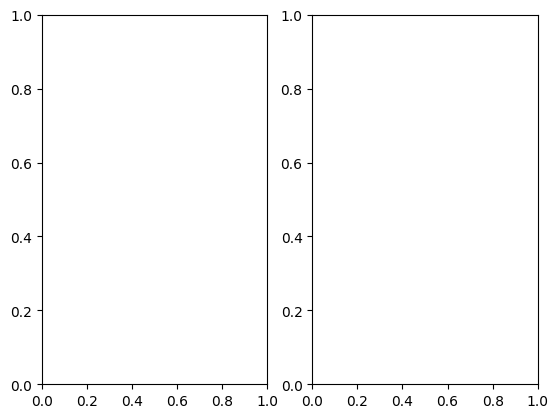

In [97]:
epochs = [i for i in range(10)]

fig, ax = plt.subplots(1, 2)

train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy' )
ax[0].plot(epochs, val_acc, 'go-', label = 'Test Accuracy' )
ax[0].set_title('Train and Test Accuracy across Epochs')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy Scores')


ax[1].plot(epochs, train_loss, 'go-', label = 'Training Loss' )
ax[1].plot(epochs, val_loss, 'go-', label = 'Test Loss' )
ax[1].set_title('Train and Test Loss across Epochs')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Losses')

In [ ]:
predictions = model.predict(test_x)

classes_pred = np.argmax(predictions, axis = 1)

print(classification_report(test_y, classes_pred))